<a href="https://colab.research.google.com/github/mada2112/Segmenting-and-Clustering-Neighborhoods-in-Toronto/blob/main/Segmenting_and_Clustering_Neighborhoods_in_Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmenting and Clustering Neighborhoods in Toronto

## Libraries

In [ ]:
!pip install lxml bs4 html5lib
!conda update -n base -c defaults conda
import pandas as pd
import numpy as np
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

/bin/bash: conda: command not found


## Scraping and Cleaning the Data

In [ ]:
to_hoods = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1011037969')[0]

In [ ]:
to_hoods = to_hoods[to_hoods['Borough']!='Not assigned']

In [ ]:
to_hoods['Neighbourhood']=np.where(to_hoods['Neighbourhood']=='Not assigned',to_hoods['Borough'],to_hoods['Neighbourhood']) 
#using np.where(condition,y,n) to replace any 'Not assigned' values in the Neighbourhood column with the values in the Borough column

In [ ]:
to_hoods = to_hoods.rename(columns={'Neighbourhood' : 'Neighborhood'}) #converting the canadian spelling to american to avoid conflicts

In [ ]:
to_hoods.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [ ]:
to_hoods.shape

(103, 3)

In [ ]:
to_hoods = to_hoods.groupby(['Postal Code'], sort=False).agg(', '.join)

In [ ]:
to_hoods.reset_index(drop= False)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [ ]:
to_hoods

,Borough,Neighborhood
Postal Code,,
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront"
M6A,North York,"Lawrence Manor, Lawrence Heights"
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...
M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
M4Y,Downtown Toronto,Church and Wellesley
M7Y,East Toronto,"Business reply mail Processing Centre, South C..."


## Coordiantes for each neighborhood

In [ ]:
lat_lng_coords = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lng_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## Latitude and Longitude values

In [ ]:
to_hoods_coords = pd.merge(to_hoods,lat_lng_coords,on='Postal Code')
to_hoods_coords

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [ ]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [ ]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(to_hoods_coords['Latitude'], to_hoods_coords['Longitude'], to_hoods_coords['Borough'], to_hoods_coords['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## API

In [ ]:
CLIENT_ID = 'PVM454TJSFO2OJDHJJCDXHNPFFVD30T4FZFBRBO5YKAQ1E4G' # your Foursquare ID
CLIENT_SECRET = '3EA21F25FU2XBVCUVJSDUCFI1IQEUKRWUZ2IPA240DGSNDOF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

## Toronto has sprawling neighborhoods therefore the radius is set to 1000m

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius= 1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Results

In [ ]:
toronto_venues = getNearbyVenues(names=to_hoods_coords['Neighborhood'],
                                   latitudes=to_hoods_coords['Latitude'],
                                   longitudes=to_hoods_coords['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [ ]:
print(toronto_venues.shape)
toronto_venues.head()

(4740, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Bruno's valu-mart,43.746143,-79.324630,Grocery Store
2,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
3,Parkwoods,43.753259,-79.329656,A&W,43.760643,-79.326865,Fast Food Restaurant
4,Parkwoods,43.753259,-79.329656,High Street Fish & Chips,43.745260,-79.324949,Fish & Chips Shop


## Number of venues per neighborhood

In [ ]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,48,48,48,48,48,48
"Alderwood, Long Branch",24,24,24,24,24,24
"Bathurst Manor, Wilson Heights, Downsview North",29,29,29,29,29,29
Bayview Village,17,17,17,17,17,17
"Bedford Park, Lawrence Manor East",40,40,40,40,40,40
...,...,...,...,...,...,...
"Willowdale, Willowdale West",13,13,13,13,13,13
Woburn,9,9,9,9,9,9
Woodbine Heights,28,28,28,28,28,28


In [ ]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 323 uniques categories.


## Preparing the data for clustering by running one hot encoding

In [ ]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Zoo,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,...,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
toronto_onehot.shape

(4740, 323)

## Top 5 venue types in each neighborhood

In [ ]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Zoo,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Botanical Garden,...,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.041667,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.020833,0.0,0.0,0.0,0.041667,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.020833,0.0,0.0,0.0,0.000,0.000,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.041667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000,0.000,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000,0.068966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000,0.000,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000,0.117647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000,0.000,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.025,0.0,0.025000,0.025000,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.025,0.000000,0.0,0.0,0.0,0.000000,0.0,0.025000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.025000,0.0,0.0,0.0,0.0,0.025,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.025000,0.000000,0.0,0.0,0.0,0.025,0.025,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.076923,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000000,0.0,0.0,0.0,0.076923,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000

In [ ]:
toronto_grouped.shape

(98, 323)

In [ ]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                  venue  freq
0    Chinese Restaurant  0.15
1         Shopping Mall  0.08
2  Caribbean Restaurant  0.04
3           Pizza Place  0.04
4                Bakery  0.04


----Alderwood, Long Branch----
            venue  freq
0  Discount Store  0.12
1     Pizza Place  0.08
2            Park  0.08
3      Playground  0.04
4   Shopping Mall  0.04


----Bathurst Manor, Wilson Heights, Downsview North----
         venue  freq
0         Bank  0.07
1  Pizza Place  0.07
2         Park  0.07
3  Coffee Shop  0.07
4     Ski Area  0.03


----Bayview Village----
                 venue  freq
0                 Bank  0.12
1          Gas Station  0.12
2        Grocery Store  0.12
3         Intersection  0.12
4  Japanese Restaurant  0.12


----Bedford Park, Lawrence Manor East----
                  venue  freq
0           Coffee Shop  0.08
1        Sandwich Place  0.05
2                  Bank  0.05
3            Restaurant  0.05
4  Fast Food Restaurant  0.05


----Berczy Park

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


----Humewood-Cedarvale----
               venue  freq
0  Convenience Store  0.07
1        Pizza Place  0.07
2      Grocery Store  0.07
3        Coffee Shop  0.07
4     Ice Cream Shop  0.04


----India Bazaar, The Beaches West----
                  venue  freq
0     Indian Restaurant  0.09
1           Coffee Shop  0.06
2                  Park  0.04
3  Fast Food Restaurant  0.04
4                  Café  0.04


----Islington Avenue, Humber Valley Village----
               venue  freq
0           Pharmacy  0.18
1               Bank  0.09
2  Convenience Store  0.09
3         Playground  0.09
4        Golf Course  0.09


----Kennedy Park, Ionview, East Birchmount Park----
                  venue  freq
0    Chinese Restaurant  0.14
1           Coffee Shop  0.10
2  Fast Food Restaurant  0.07
3           Pizza Place  0.07
4        Discount Store  0.07


----Kensington Market, Chinatown, Grange Park----
                           venue  freq
0                           Café  0.09
1             

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## 10 most common venues per neighborhood

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Supermarket,Bakery,Caribbean Restaurant,Pizza Place,Pool Hall,Sri Lankan Restaurant,Breakfast Spot,Skating Rink
1,"Alderwood, Long Branch",Discount Store,Pizza Place,Park,Playground,Pub,Bagel Shop,Donut Shop,Garden Center,Intersection,Gas Station
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Park,Pizza Place,Coffee Shop,Pharmacy,Sushi Restaurant,Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,Sandwich Place
3,Bayview Village,Gas Station,Japanese Restaurant,Grocery Store,Intersection,Bank,Chinese Restaurant,Café,Playground,Park,Skating Rink
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Fast Food Restaurant,Restaurant,Sandwich Place,Bank,Thai Restaurant,Liquor Store,Indian Restaurant,Baby Store,Bagel Shop


In [ ]:
neighborhoods_venues_sorted.shape

(98, 11)

## Optimal K value using the Elbow Method

In [ ]:
distortions = []
K = range(1,9)
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
    distortions.append(kmeans.inertia_)

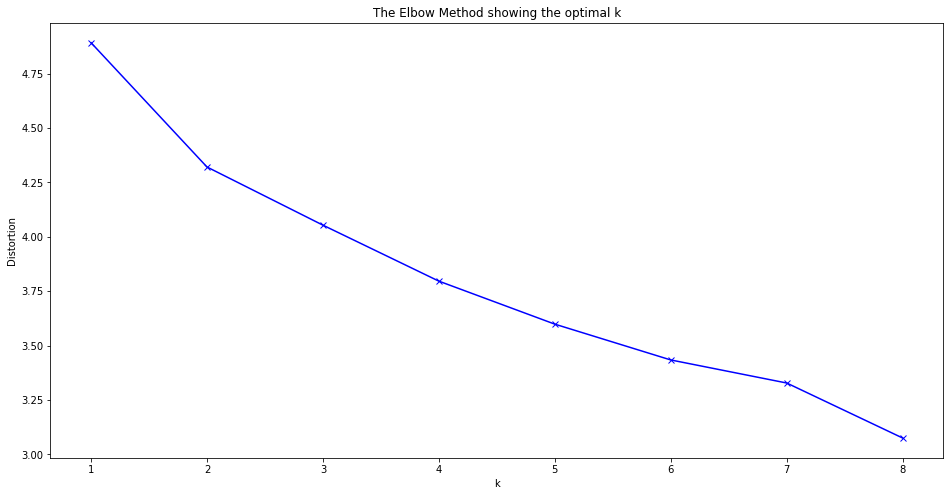

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## KMean analysis using k=4

In [ ]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 1, 1, 3, 1, 1, 1], dtype=int32)

## Removing neighborhoods that do not contain any venues

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = to_hoods_coords

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,3.0,Park,Pharmacy,Shopping Mall,Bus Stop,Fast Food Restaurant,Intersection,Skating Rink,Shop & Service,Fish & Chips Shop,Food & Drink Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,2.0,Coffee Shop,Park,Hockey Arena,Golf Course,Men's Store,Pizza Place,Lounge,Portuguese Restaurant,Sporting Goods Shop,Intersection
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Pub,Restaurant,Sushi Restaurant,Café,Pizza Place,Sandwich Place,Italian Restaurant,Bakery,Park
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2.0,Fast Food Restaurant,Coffee Shop,Clothing Store,Restaurant,Furniture / Home Store,Sushi Restaurant,Fried Chicken Joint,Paper / Office Supplies Store,Vietnamese Restaurant,Dessert Shop
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,Sushi Restaurant,Coffee Shop,Japanese Restaurant,Park,Pizza Place,Café,Clothing Store,Middle Eastern Restaurant,Dessert Shop,Dance Studio


In [ ]:
toronto_merged[toronto_merged['Cluster Labels'].isna()]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
toronto_merged.dropna(subset = ["Cluster Labels"], inplace=True)

## Map

In [ ]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = ['blue', 'orange', 'red', 'yellow', 'black', 'cadetblue']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
map_clusters.save("map_clusters.html")

## Outlier (Suburban neighborhood near highway junction)

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,"York Mills, Silver Hills",0.0,Park,Pool,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
101,"Old Mill South, King's Mill Park, Sunnylea, Hu...",0.0,Park,Eastern European Restaurant,Italian Restaurant,Shopping Mall,Bus Stop,Ice Cream Shop,Gym / Fitness Center,Entertainment Service,Drugstore,Dry Cleaner


## Urban (Downtown + Airport + Univerities + Subway Line):

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Regent Park, Harbourfront",1.0,Coffee Shop,Pub,Restaurant,Sushi Restaurant,Café,Pizza Place,Sandwich Place,Italian Restaurant,Bakery,Park
4,"Queen's Park, Ontario Provincial Government",1.0,Sushi Restaurant,Coffee Shop,Japanese Restaurant,Park,Pizza Place,Café,Clothing Store,Middle Eastern Restaurant,Dessert Shop,Dance Studio
7,Don Mills,1.0,Restaurant,Gym,Coffee Shop,Pizza Place,Supermarket,Bank,Japanese Restaurant,Clothing Store,Burger Joint,Café
9,"Garden District, Ryerson",1.0,Japanese Restaurant,Coffee Shop,Sushi Restaurant,Café,Gastropub,Italian Restaurant,Restaurant,Diner,Bakery,Theater
13,Don Mills,1.0,Restaurant,Gym,Coffee Shop,Pizza Place,Supermarket,Bank,Japanese Restaurant,Clothing Store,Burger Joint,Café
14,Woodbine Heights,1.0,Coffee Shop,Park,Café,Pizza Place,Sandwich Place,Ice Cream Shop,Beer Store,Liquor Store,Thai Restaurant,Bus Stop
15,St. James Town,1.0,Café,Coffee Shop,Restaurant,Italian Restaurant,Beer Bar,Deli / Bodega,Bakery,Seafood Restaurant,Gym,Japanese Restaurant
19,The Beaches,1.0,Pub,Coffee Shop,Beach,Japanese Restaurant,Pizza Place,Breakfast Spot,Sandwich Place,Burger Joint,Bar,Ice Cream Shop
20,Berczy Park,1.0,Coffee Shop,Café,Restaurant,Japanese Restaurant,Park,Cocktail Bar,Seafood Restaurant,Beer Bar,Deli / Bodega,Hotel
24,Central Bay Street,1.0,Sushi Restaurant,Coffee Shop,Japanese Restaurant,Burrito Place,Café,Ramen Restaurant,Clothing Store,Park,Modern European Restaurant,Theater


## Suburbs

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,2.0,Coffee Shop,Park,Hockey Arena,Golf Course,Men's Store,Pizza Place,Lounge,Portuguese Restaurant,Sporting Goods Shop,Intersection
3,"Lawrence Manor, Lawrence Heights",2.0,Fast Food Restaurant,Coffee Shop,Clothing Store,Restaurant,Furniture / Home Store,Sushi Restaurant,Fried Chicken Joint,Paper / Office Supplies Store,Vietnamese Restaurant,Dessert Shop
6,"Malvern, Rouge",2.0,Fast Food Restaurant,Trail,Greek Restaurant,Spa,Sandwich Place,Supermarket,Caribbean Restaurant,Bank,Bakery,Chinese Restaurant
8,"Parkview Hill, Woodbine Gardens",2.0,Brewery,Pizza Place,Gym / Fitness Center,Breakfast Spot,Gastropub,Bakery,Bank,Flea Market,Construction & Landscaping,Soccer Stadium
10,Glencairn,2.0,Fast Food Restaurant,Grocery Store,Gas Station,Italian Restaurant,Coffee Shop,Playground,Latin American Restaurant,Furniture / Home Store,Bank,Sandwich Place
16,Humewood-Cedarvale,2.0,Convenience Store,Coffee Shop,Grocery Store,Pizza Place,Dance Studio,Deli / Bodega,Optical Shop,Restaurant,Caribbean Restaurant,Intersection
17,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",2.0,Coffee Shop,Beer Store,Gas Station,Convenience Store,Pharmacy,Pizza Place,College Rec Center,Fish & Chips Shop,Café,Shopping Mall
18,"Guildwood, Morningside, West Hill",2.0,Fast Food Restaurant,Coffee Shop,Bank,Pizza Place,Pharmacy,Restaurant,Sandwich Place,Donut Shop,Fried Chicken Joint,Grocery Store
23,Leaside,2.0,Coffee Shop,Burger Joint,Grocery Store,Sporting Goods Shop,Breakfast Spot,Bank,Sandwich Place,Sushi Restaurant,Brewery,Electronics Store
26,Cedarbrae,2.0,Bakery,Gas Station,Indian Restaurant,Bank,Grocery Store,Thai Restaurant,Fried Chicken Joint,Sporting Goods Shop,Fast Food Restaurant,Yoga Studio


## Park Areas + Waterfront

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,3.0,Park,Pharmacy,Shopping Mall,Bus Stop,Fast Food Restaurant,Intersection,Skating Rink,Shop & Service,Fish & Chips Shop,Food & Drink Shop
5,"Islington Avenue, Humber Valley Village",3.0,Pharmacy,Playground,Park,Bank,Café,Shopping Mall,Golf Course,Skating Rink,Grocery Store,Convenience Store
11,"West Deane Park, Princess Gardens, Martin Grov...",3.0,Park,Pizza Place,Hotel,Fish & Chips Shop,Bank,Restaurant,Clothing Store,Grocery Store,Gym,Mexican Restaurant
12,"Rouge Hill, Port Union, Highland Creek",3.0,Playground,Park,Burger Joint,Italian Restaurant,Breakfast Spot,Cosmetics Shop,Creperie,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant
21,Caledonia-Fairbanks,3.0,Park,Pharmacy,Bus Stop,Grocery Store,Bus Line,Falafel Restaurant,Café,Bank,Bakery,Mexican Restaurant
22,Woburn,3.0,Park,Coffee Shop,Fast Food Restaurant,Mobile Phone Shop,Pharmacy,Chinese Restaurant,Indian Restaurant,Entertainment Service,Drugstore,Dry Cleaner
27,Hillcrest Village,3.0,Pharmacy,Park,Coffee Shop,Recreation Center,Fast Food Restaurant,Shopping Mall,Sandwich Place,Korean Restaurant,Bank,Bakery
49,"North Park, Maple Leaf Park, Upwood Park",3.0,Coffee Shop,Intersection,Convenience Store,Gas Station,Chinese Restaurant,Athletics & Sports,Park,Bakery,Dim Sum Restaurant,Yoga Studio
50,Humber Summit,3.0,Medical Center,Park,Bank,Italian Restaurant,Electronics Store,Arts & Crafts Store,Shopping Mall,Bakery,Pharmacy,Event Space
57,"Humberlea, Emery",3.0,Bakery,Gas Station,Convenience Store,Auto Garage,Golf Course,Discount Store,Park,Storage Facility,Elementary School,Dry Cleaner
